Here you may get familiar with PU learning, play with mixtures of laplace and normal distributions, test DEDPUL and other methods.

The notebook is based on the paper "DEDPUL: Method for Positive-Unlabeled Learning based on Density Estimation". Note that in the original paper proportions and posteriors of Positive class are presented and estimated, while methods in this notebook by default estimate those for Negative class. To convert, just substract the estimates from 1.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, laplace
import random

from sklearn.metrics import accuracy_score, log_loss, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, brier_score_loss, f1_score

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
from IPython import display

from algorithms import *
from utils import *
from KMPE import *
from NN_functions import *

import warnings
warnings.filterwarnings('ignore')

# What is PU learning?

Positive-Unlabeled (PU) Classification is a problem of semi-supervised learning on the data that is corrupted in a specific way. Unlike supervised binary classification, PU classification does not require labeled samples from both classes for training. Instead, two samples are required: a labeled sample from Positive (P) class, and an Unlabeled (U) sample with mixed data from both Positive (P) and Negative (N) classes with generally unknown mixing proportions. The objectives are: (i) to estimate the proportions of P and N in U and (ii) to classify it, i.e. to assign probability of being P rather than N for each instance in U. The first problem is reffered to as Mixture Proportions Estimation; the second - as PU Classification.

Several methods that solve these problems are highlighted in this notebook.

# Data

In [2]:
# specify distributions to sample data from.

# mode = 'normal'
mode ='laplace'

In [5]:
# feel free to play with parameters of distributions;
# initially we recommend to stick to cases of s1=s2

# centers and standard deviations of P and N distributions
mu1 = 0
s1 = 1
mu2 = 4
s2 = 1

# alpha is proportion of N in U; (1 - alpha) is proportion of P in U; these will be unknown for methods below;
# note that not alpha but alpha^* (computed below) is the proportion that the methods are supposed to identify 
# (find out why in the paper)
alpha = 0.75

if mode == 'normal':
    p1 = lambda x: norm.pdf(x, mu1, s1)
    p2 = lambda x: norm.pdf(x, mu2, s2)
    pm = lambda x: p1(x) * (1 - alpha) + p2(x) * alpha
elif mode == 'laplace':
    p1 = lambda x: laplace.pdf(x, mu1, s1)
    p2 = lambda x: laplace.pdf(x, mu2, s2)
    pm = lambda x: p1(x) * (1 - alpha) + p2(x) * alpha

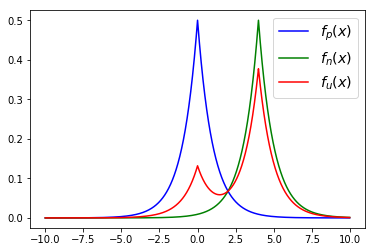

In [6]:
# These are the distributions.

plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot([x/100 for x in range(-1000, 1000)], [pm(x/100) for x in range(-1000, 1000)], 'r')

plt.legend(handles=(Line2D([], [], linestyle='-', color='b'),
                        Line2D([], [], linestyle='-', color='g'),
                        Line2D([], [], linestyle='-', color='r')),
               labels=('$f_p(x)$', '$f_n(x)$', '$f_u(x)$'),
          fontsize='x-large')

Lets generate samples from the Positive and the Unlabeled distributions $f_p(x)$ and $f_u(x)$. Remember, we don't have Negative data from $f_n(x)$.

In [7]:
if mode == 'normal':
    sampler = np.random.normal
elif mode == 'laplace':
    sampler = np.random.laplace

In [8]:
mix_size =2500
pos_size = 500

mix_data_test = np.append(sampler(mu1, s1, int(mix_size * (1 - alpha))), 
                          sampler(mu2, s2, int(mix_size * alpha)))
pos_data_test = sampler(mu1, s1, int(pos_size))

data_test = np.append(mix_data_test, pos_data_test).reshape((-1, 1))
target_test = np.append(np.array([1] * mix_size), np.array([0] * pos_size))
target_test_true = np.append(np.array([0] * int(mix_size * (1 - alpha))), np.array([1] * int(mix_size * alpha)))
target_test_true = np.append(target_test_true, np.array([2] * pos_size))

mix_data_test = mix_data_test.reshape([-1, 1])
pos_data_test = pos_data_test.reshape([-1, 1])

data_test = np.concatenate((data_test, target_test.reshape(-1, 1), target_test_true.reshape(-1, 1)), axis=1)
np.random.shuffle(data_test)
target_test = data_test[:, 1]
target_test_true = data_test[:, 2]
data_test = data_test[:, 0].reshape(-1, 1)

In [11]:
# here we may estimate ground truth alpha^* for limited number of cases: 
# laplace and normal distributions where either mean or std coincide.
# alpha^* is the desired proportion that the methods are supposed to identify.

cons_alpha = estimate_cons_alpha(mu2 - mu1, s2 / s1, alpha, mode)
print('alpha* =', cons_alpha)

alpha* = 0.7362632708334493


Below several methods are applied to solve MPE and PU Classification

# DEDPUL

The short way:

In [17]:
test_alpha, poster = estimate_poster_cv(data_test, target_test, estimator='dedpul', alpha=None,
                                         estimate_poster_options={'disp': False},
                                         estimate_diff_options={},
                                         estimate_preds_cv_options={'NN': {
                                             'fun': estimate_preds_cv,
                                             'cv': 3, 'n_networks': 10, 'lr': 0.0005, 'hid_dim': 32,
                                             'n_hid_layers': 1, 'random_state': 0, 'train_nn_options': {
                                                 'n_epochs': 100, 'batch_size': 128,
                                                 'n_batches': 20, 'n_early_stop': 3, 'disp': False
                                             }}
                                         }
                                       )

print('alpha:', test_alpha, '\nerror:', abs(test_alpha - cons_alpha))

alpha: 0.7205432935573386 
error: 0.01571997727611074


The short-but-a-bit-longer way:

In [18]:
# estimate y(x), the predictions of NTC

preds = estimate_preds_cv(data_test, target_test, n_networks=10,
                          train_nn_options={'n_epochs': 200, 'batch_size': 128,
                                            'n_batches': 20, 'n_early_stop': 3, 'disp': False, 'loss_function': 'log'})

print('ac', accuracy_score(target_test, preds.round()))
print('roc', roc_auc_score(target_test, preds))

ac 0.7623333333333333
roc 0.8514223999999999


In [24]:
bw_mix = 0.05
bw_pos = 0.1
threshold = preds[target_test==1].mean()
k_neighbours = 150
MT_coef = 0.25

In [25]:
# estimate density ratio g_p(y)/g_u(y) with tuned bandwidths, apply heuristics

diff = estimate_diff(preds, target_test,
                     bw_mix, bw_pos, 'logit', threshold, k_neighbours,
                     MT=True, MT_coef=MT_coef, decay_MT_coef=False)

In [28]:
# plt.plot(preds[target_test==1], diff, 'bo')

In [29]:
# Estimate priors alpha^* and posteriors f^*(p | x) with EM algorithm (if converges) 
# or with alternative max_slope otherwise

test_alpha, poster = estimate_poster_em(diff, mode='dedpul', converge=True, nonconverge=True, 
                                        max_diff=0.05, step=0.0025, alpha_as_mean_poster=True)#, alpha=cons_alpha)
print('alpha:', test_alpha, '\nmean_poster:', np.mean(poster), '\ncons_alpha:', cons_alpha)

alpha: 0.7206922244778192 
mean_poster: 0.7207010883465599 
cons_alpha: 0.7362632708334493


Text(0.5,0,'$y(x)$')

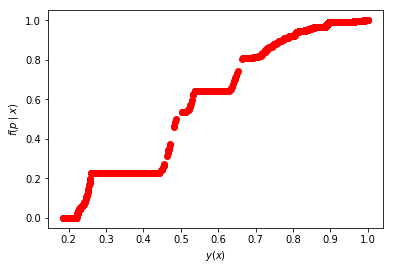

In [30]:
plt.plot(preds[target_test==1], poster, 'ro')
plt.ylabel('$f(p \mid x)$')
plt.xlabel('$y(x)$')

Analyze results:

In [31]:
# compute performance measures

realistic_poster = np.apply_along_axis(lambda x: (pm(x) - p1(x) * (1 - cons_alpha)) / pm(x), -1, 
                    data_test[target_test_true != 2].reshape(-1,))
realistic_poster[realistic_poster < 0] = 0

print('accuracy:', 
      accuracy_score(target_test_true[target_test_true != 2], poster.round()))
print('ROC-AUC:',
      roc_auc_score(target_test_true[target_test_true != 2], poster))
print('brier:',
      brier_score_loss(target_test_true[target_test_true != 2], poster))
print('true MAE:',
      mean_absolute_error(realistic_poster, poster))
print('true RMSE:',
      np.sqrt(mean_squared_error(realistic_poster, poster)))

accuracy: 0.9388
ROC-AUC: 0.9743057066666667
brier: 0.049752449534337224
true MAE: 0.019637262401361943
true RMSE: 0.04837518981983168


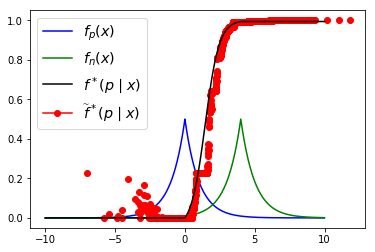

In [32]:
# illustrate performance graphically. The closer red circles to black line - the better.

plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot(data_test[target_test_true != 2], poster, 'ro')
plt.plot([x/100 for x in range(-1000, 1000)], [max((pm(x/100) - p1(x/100) * (1 - cons_alpha)) / pm(x/100), 0)
                                               for x in range(-1000, 1000)], 'k')

plt.legend(handles=(Line2D([], [], linestyle='-', color='b'),
                        Line2D([], [], linestyle='-', color='g'),
                        Line2D([], [], linestyle='-', color='k'),
                        Line2D([], [], color='r', marker='o')),
               labels=('$f_p(x)$', '$f_n(x)$', '$f^*(p \mid x)$', '$\widetilde{f}^*(p \mid x)$'),
          fontsize='x-large')

In [34]:
# # illustrate max_slope: argument of the highest point on the second graph is the estimate \alpha_n^*

# posters = []
# step = 0.005
# for test_alpha_ in np.arange(0, 1+step, step):
#     poster_ = 1 - diff * (1 - test_alpha_)
#     poster_[poster_ < 0] = 0
#     posters.append(np.mean(poster_) - test_alpha_)


# fig, axs = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(6, 10))
# axs[0].plot(np.arange(0, 1+step, step), posters)
# axs[1].plot(np.arange(2*step, 1+step, step), np.diff(np.diff(posters)))

# EN

In [36]:
# EN_alpha, EN_poster = estimate_poster_en(preds, target_test, alpha=None, estimator='e1', e3_quantile=0.95)

EN_alpha, EN_poster = estimate_poster_em(preds=preds, target=target_test, mode='en', converge=True, nonconverge=True, 
                                         max_diff=0.05, step=0.0025)

print('EN priors =', EN_alpha)
print('EN posters mean =', np.mean(EN_poster))
print()

EN_realistic_poster = np.apply_along_axis(lambda x: (pm(x) - p1(x) * (1 - cons_alpha)) / pm(x), -1, 
                        data_test[target_test_true != 2].reshape(-1, ))

print('accuracy:', 
      accuracy_score(target_test_true[target_test_true != 2], EN_poster.round()))
print('ROC-AUC:',
      roc_auc_score(target_test_true[target_test_true != 2], EN_poster))
print('brier:',
      brier_score_loss(target_test_true[target_test_true != 2], EN_poster.round()))
print('MAE:',
      mean_absolute_error(EN_realistic_poster, EN_poster))
print('RMSE:',
      np.sqrt(mean_squared_error(EN_realistic_poster, EN_poster)))

EN priors = 0.7524910885777895
EN posters mean = 0.7524991535562248

accuracy: 0.9392
ROC-AUC: 0.9745902933333332
brier: 0.0608
MAE: 0.024162067072688562
RMSE: 0.049786074006992025


(0, 1)

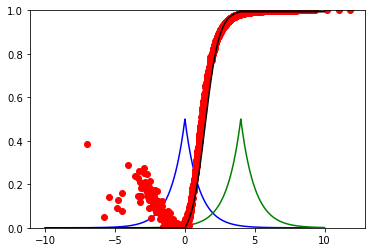

In [37]:
plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot(data_test[target_test_true != 2], EN_poster, 'ro')
plt.plot([x/100 for x in range(-1000, 1000)], [max((pm(x/100) - p1(x/100) * (1 - cons_alpha)) / pm(x/100), 0) 
                                               for x in range(-1000, 1000)], 'k')
plt.ylim(0, 1)

# nnRE

In [44]:
nnre_poster = estimate_preds_cv(data_test, target_test, n_networks=1, training_mode='nnre', alpha=cons_alpha,
                                n_hid_layers=3,
                          train_nn_options={'n_epochs': 50, 'batch_size': 128, 'loss_function': 'brier',
                                            'n_batches': 30, 'n_early_stop': 20, 'disp': False})[target_test == 1]


nnre_realistic_poster = np.apply_along_axis(lambda x: (pm(x) - p1(x) * (1 - cons_alpha)) / pm(x), -1, 
                        data_test[target_test_true != 2].reshape(-1, ))

print('accuracy:', 
      accuracy_score(target_test_true[target_test_true != 2], nnre_poster.round()))
print('ROC-AUC:',
      roc_auc_score(target_test_true[target_test_true != 2], nnre_poster))
print('brier:',
      brier_score_loss(target_test_true[target_test_true != 2], nnre_poster.round()))
print('MAE:',
      mean_absolute_error(nnre_realistic_poster, nnre_poster))
print('RMSE:',
      np.sqrt(mean_squared_error(nnre_realistic_poster, nnre_poster)))

accuracy: 0.938
ROC-AUC: 0.9754794666666666
brier: 0.062
MAE: 0.021058501952421746
RMSE: 0.035286697232042516


(0, 1)

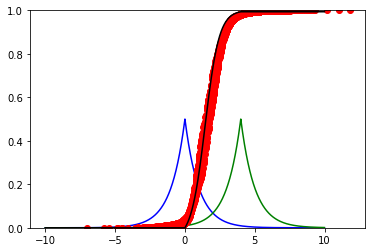

In [45]:
plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot(data_test[target_test_true != 2].flatten(), nnre_poster, 'ro')
plt.plot([x/100 for x in range(-1000, 1000)], [max((pm(x/100) - p1(x/100) * (1 - cons_alpha)) / pm(x/100), 0) 
                                               for x in range(-1000, 1000)], 'k')
plt.ylim(0, 1)

# KM Proportions Estimation

implementation is taken from http://web.eecs.umich.edu/~cscott/code.html#kmpe

In [22]:
# KM_1, KM_2 = wrapper(mix_data_test, pos_data_test, epsilon=0.04, lambda_lower_bound=0.5, lambda_upper_bound=10, 
#                      KM_1=True, KM_2=True)
# KM_1 = 1 - KM_1
# KM_2 = 1 - KM_2

# print(KM_1)
# print(KM_2)